In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
"""
Functions written for ease of usage of the model.
"""

def get_features_targets(df: pd.DataFrame, 
                         feature_names: list[str], 
                         target_names: list[str]) -> tuple[pd.DataFrame, pd.DataFrame]:
    df_feature = pd.DataFrame(df[feature_names[:]])
    df_target = pd.DataFrame(df[target_names[:]])
    return df_feature, df_target

def plot_data(df: pd.DataFrame, 
              feature: str, 
              target: str):
    sns.set()
    feature = pd.DataFrame(df[feature])
    target = pd.DataFrame(df[target])
    plt.scatter(feature, target)

# Finds xy correlation constant
def calc_correlation(df: pd.DataFrame,
                     feature: str,
                     target: str):
    f = df[feature].to_numpy()
    t = df[target].to_numpy()
    coef = np.corrcoef(f, t)[0][1]
    if np.isnan(coef):
        return 0
    return coef

def get_numpy_features(df: pd.DataFrame,
                       feature_names: list[str],
                       target_names: list[str]):
    f_n = df[feature_names[:]].to_numpy()
    t_n = df[target_names[:]].to_numpy()
    return f_n, t_n

In [3]:
"""
Getting Data from data.csv.
"""

# Sanity check: stops program if the number of datapoints differ across columns
try:
    df: pd.DataFrame = pd.read_csv("../data/data.csv")
    if (len(set(df.count())) != 1):
        raise Exception("Datapoints differ across columns")
except Exception as e:
    print(f"Caught: {e}")

# print(df)

# Independant Variable
VAR_Y = 'YEAR'
VAR_C = 'CROP_YIELD_BPA'
VAR_CU = 'CROP_YIELD_USA_BPA'

# Dependant Variables

VAR_TEMP = 'TEMP_F'
VAR_RAIN = 'RAINFALL_IN'
VAR_WIND = 'WINDSPEED_MPH'
VAR_SNOW = 'SNOWFALL_IN'
VAR_PEST = 'PESTICIDE_M_TON'
VAR_GDP = 'GDP_$'
VAR_FERT = 'FERTILISER_M_TON'

vars = [VAR_TEMP, VAR_RAIN, VAR_WIND, VAR_SNOW, VAR_PEST, VAR_GDP, VAR_FERT]

df_features, df_target = get_features_targets(df, 
                                              vars, 
                                              [VAR_CU])

# print("Features: ", [df_features[f] for f in df_features])
# print("Target: ", df_target)


c:\Users\aryan\miniconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\aryan\miniconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


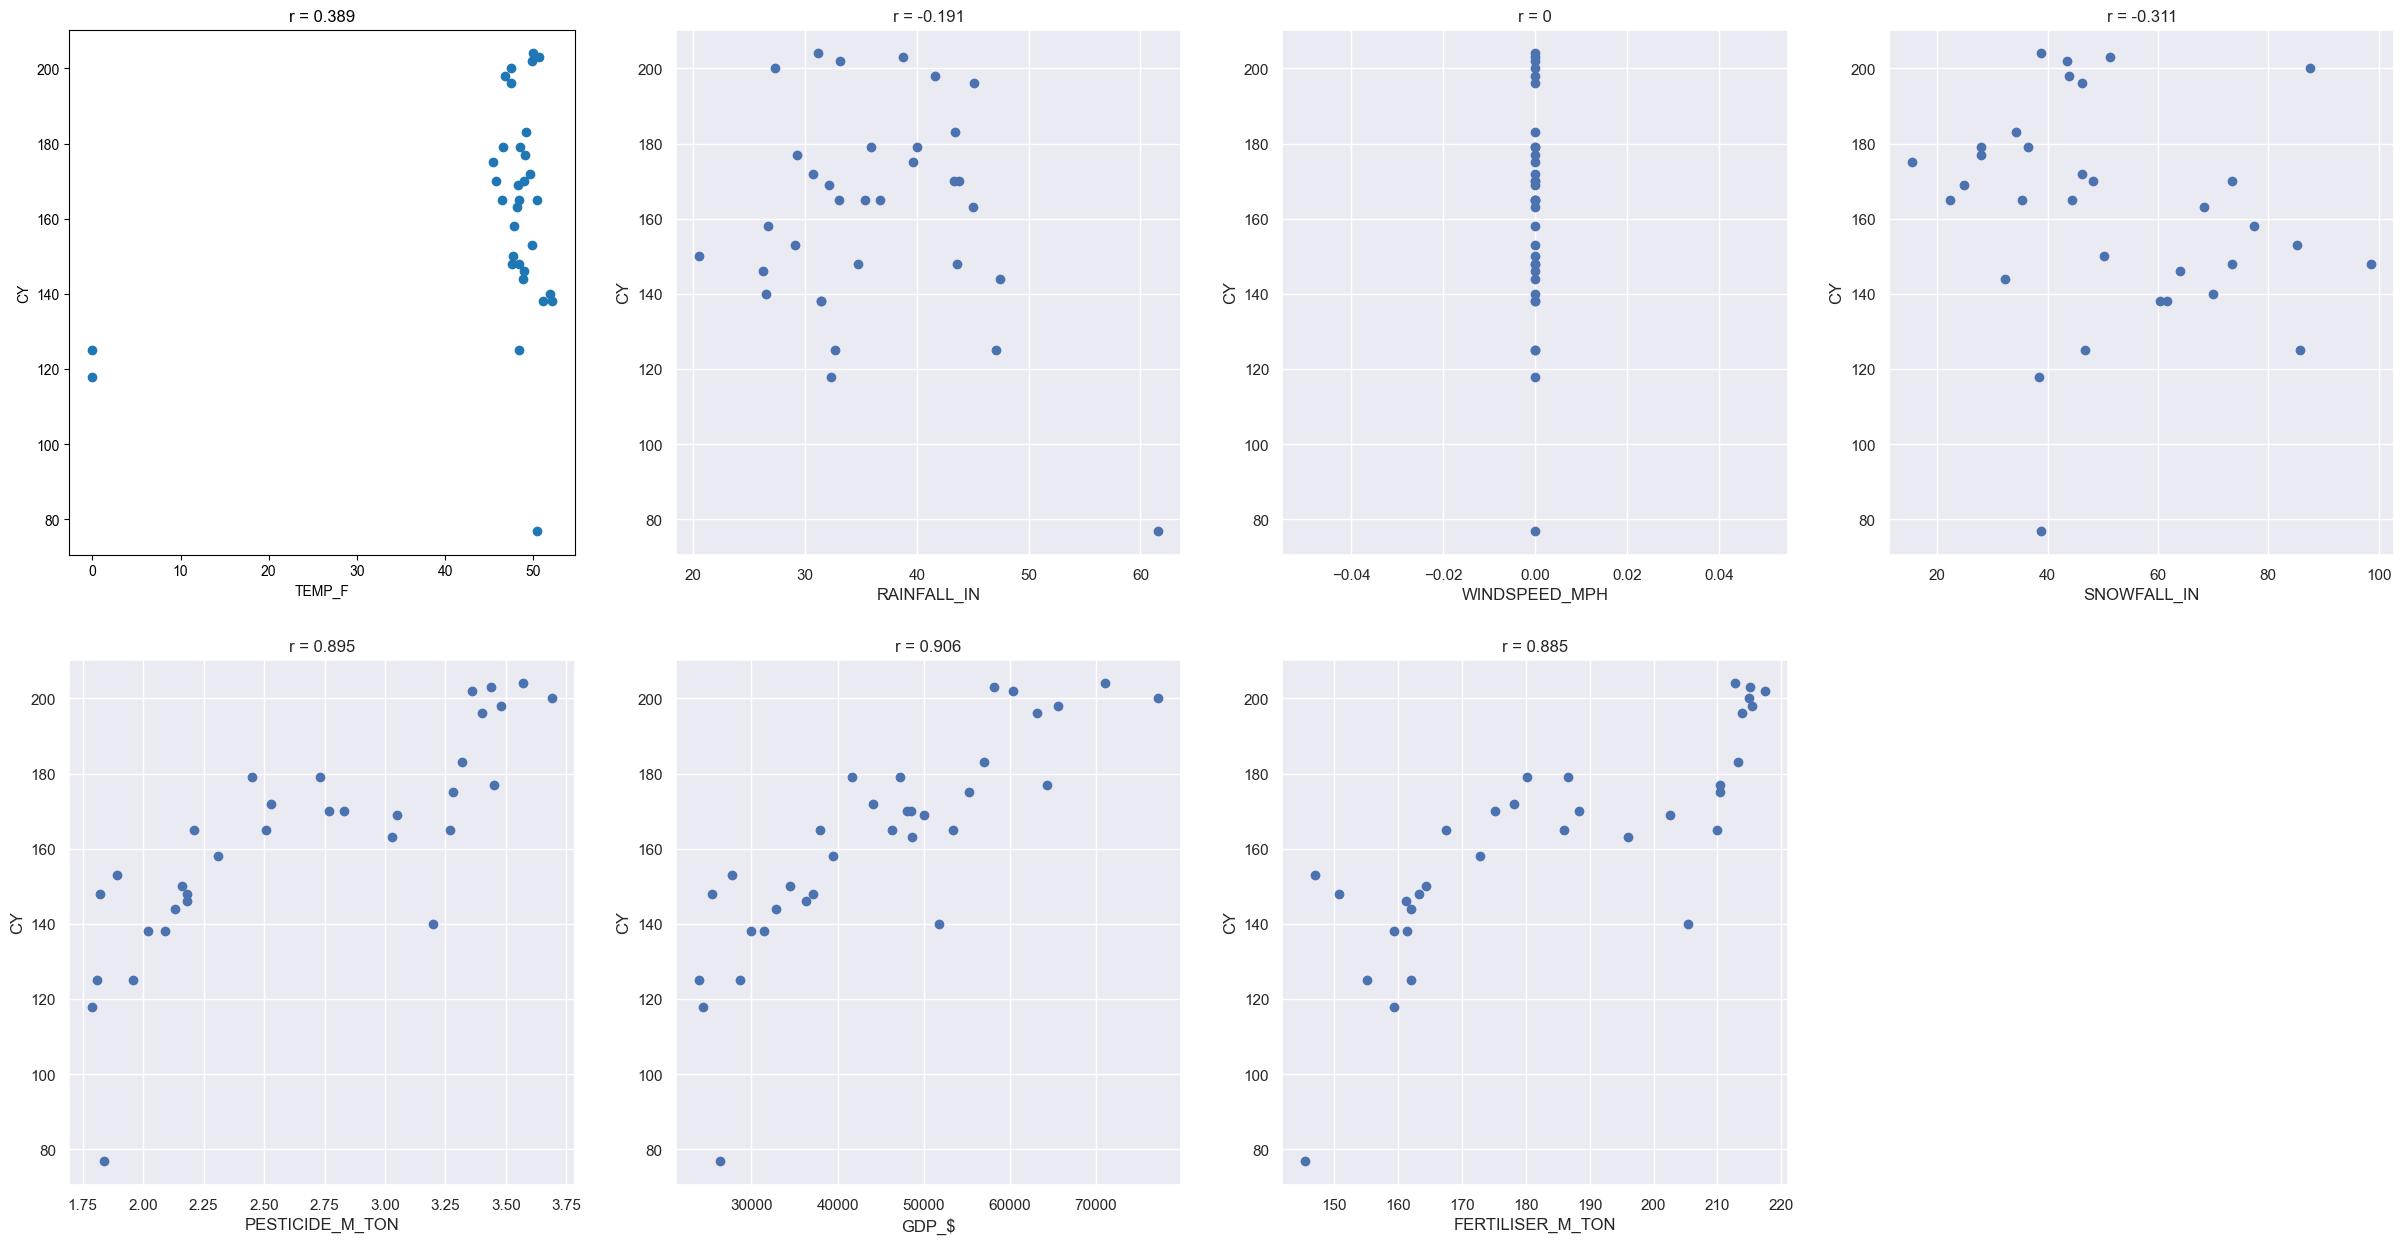

In [4]:
"""
Relationship between each dependant and independant variable

"""
plt.figure(figsize=(30, 15))

i = 1
for var in vars:
    plt.subplot(2, 4, i)
    plt.xlabel(var)
    plt.ylabel("CY")
    r = calc_correlation(df, var, VAR_CU)
    plt.title(f"r = {round(r, 3)}")
    plot_data(df, var, VAR_C)
    i += 1

plt.savefig("../data/figures/correlation.png")
# plot_data(df, dep[VAR_PEST], VAR_C)

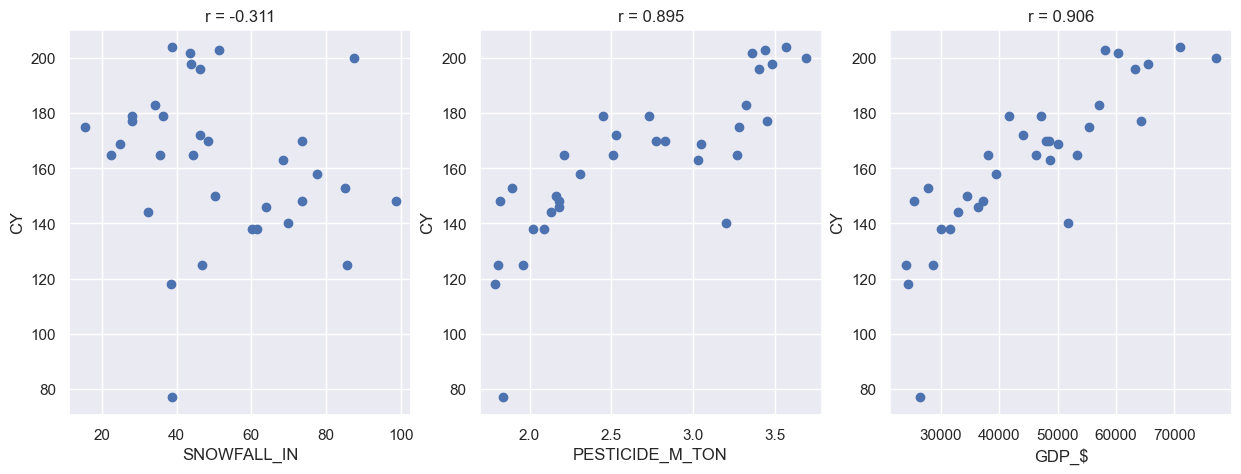

In [5]:

VAR_SNOW: 'SNOWFALL_IN'
VAR_PEST: 'PESTICIDE_M_TON'
VAR_GDP: 'GDP_$'

chosen_dep = [VAR_SNOW, VAR_PEST, VAR_GDP]

plt.figure(figsize=(15, 5))

i = 1
for var in chosen_dep:
    plt.subplot(1, 3, i)
    plt.xlabel(var)
    plt.ylabel("CY")
    r = calc_correlation(df, var, VAR_CU)
    plt.title(f"r = {round(r, 3)}")
    plot_data(df, var, VAR_C)
    i += 1

plt.savefig("../data/figures/chosendep.png")

In [45]:

# Data transformation
from regression_functions import MVF
f, t = get_numpy_features(df, ['SNOWFALL_IN', 'PESTICIDE_M_TON', 'GDP_$'], [VAR_CU])
model = MVF(f, t)
model.normalize_data()
model.gradient_descent()
print(model.weights)
print(model.costs)

[[-0.08994607]
 [ 0.37866315]
 [ 0.51020136]]
[0.48298326636761424, 0.4666686318039771, 0.4510270712683612, 0.43603076060180707, 0.42165302682464817, 0.40786830049144046, 0.39465207001812663, 0.3819808378997906, 0.3698320787407381, 0.3581841990218773, 0.3470164985334831, 0.3363091334044004, 0.32604308066160215, 0.31620010425674894, 0.3067627224990212, 0.29771417683601, 0.2890384019268606, 0.28071999695417527, 0.27274419812339407, 0.265096852300497, 0.25776439174090543, 0.250733809864411, 0.24399263803283072, 0.2375289232888793, 0.2313312070164684, 0.22538850448428907, 0.21969028523611386, 0.21422645429276757, 0.2089873341321666, 0.20396364741522, 0.1991465004267144, 0.19452736720158845, 0.19009807430822298, 0.18585078626155, 0.1817779915399097, 0.17787248918066276, 0.17412737593060051, 0.1705360339281872, 0.16709211889561945, 0.1637895488195989, 0.1606224931005888, 0.1575853621511603, 0.15467279742484086, 0.15187966185764243, 0.14920103070518873, 0.14663218275906434, 0.1441685919266901

In [34]:
%autoreload 2